<a href="https://www.kaggle.com/code/dietzschenostoevsky/backpropagation-fitting-a-curve?scriptVersionId=116017606" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Setting up training Data and Algos 

In [4]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

def plot_training (x, y, iterations=10000, aggression=3.5, noise=1) :
    global W1, W2, W3, b1, b2, b3
    fig,ax = plt.subplots(figsize=(8, 8), dpi= 80)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_aspect(1)

    xx = np.arange(0,1.01,0.01)
    yy = np.arange(0,1.01,0.01)
    X, Y = np.meshgrid(xx, yy)
    Z = ((X-0.5)**2 + (Y-1)**2)**(1/2) / (1.25)**(1/2)
    im = ax.imshow(Z, vmin=0, vmax=1, extent=[0, 1, 1, 0], cmap=blueMap)

    ax.plot(y[0],y[1], lw=1.5, color=green);

    while iterations>=0 :
        j_W1 = J_W1(x, y) * (1 + np.random.randn() * noise)
        j_W2 = J_W2(x, y) * (1 + np.random.randn() * noise)
        j_W3 = J_W3(x, y) * (1 + np.random.randn() * noise)
        j_b1 = J_b1(x, y) * (1 + np.random.randn() * noise)
        j_b2 = J_b2(x, y) * (1 + np.random.randn() * noise)
        j_b3 = J_b3(x, y) * (1 + np.random.randn() * noise)

        W1 = W1 - j_W1 * aggression
        W2 = W2 - j_W2 * aggression
        W3 = W3 - j_W3 * aggression
        b1 = b1 - j_b1 * aggression
        b2 = b2 - j_b2 * aggression
        b3 = b3 - j_b3 * aggression

        if (iterations%100==0) :
            nf = network_function(x)[-1]
            ax.plot(nf[0],nf[1], lw=2, color=magentaTrans);
        iterations -= 1

    nf = network_function(x)[-1]
    ax.plot(nf[0],nf[1], lw=2.5, color=orange);


def training_data (N = 100) :
    x = np.arange(0,1,1/N)
    y = np.array([
      16*np.sin(2*np.pi*x)**3,
      13*np.cos(2*np.pi*x) - 5*np.cos(2*2*np.pi*x) - 2*np.cos(3*2*np.pi*x)- np.cos(4*2*np.pi*x)
    ]
    ) / 20
    y = (y+1)/2
    x = np.reshape(x, (1, N))
    #y = np.reshape(y, (2, N))
    return x, y

def make_colormap(seq):
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

magenta = (0xfc/255, 0x75/255, 0xdb/255) # Brighter magenta
magentaTrans = (0xfc/255, 0x75/255, 0xdb/255, 0.1) # Brighter Transparent magenta
orange = (218/255, 171/255, 115/255)
green = (175/255, 219/255, 133/255)
white = (240/255, 245/255, 250/255)
blue1 = (70/255, 101/255, 137/255)
blue2 = (122/255, 174/255, 215/255)

blueMap = make_colormap([blue2, blue1])


Feedforward Network and Cost function

In [5]:
# PACKAGE
# First load the worksheet dependencies.
# Here is the activation function and its derivative.
sigma = lambda z : 1 / (1 + np.exp(-z))
d_sigma = lambda z : np.cosh(z/2)**(-2) / 4

# This function initialises the network with it's structure, it also resets any training already done.
def reset_network (n1 = 6, n2 = 7, random=np.random) :
    global W1, W2, W3, b1, b2, b3
    W1 = random.randn(n1, 1) / 2
    W2 = random.randn(n2, n1) / 2
    W3 = random.randn(2, n2) / 2
    b1 = random.randn(n1, 1) / 2
    b2 = random.randn(n2, 1) / 2
    b3 = random.randn(2, 1) / 2

# This function feeds forward each activation to the next layer. It returns all weighted sums and activations.
def network_function(a0) :
    z1 = W1 @ a0 + b1
    a1 = sigma(z1)
    z2 = W2 @ a1 + b2
    a2 = sigma(z2)
    z3 = W3 @ a2 + b3
    a3 = sigma(z3)
    return a0, z1, a1, z2, a2, z3, a3

# This is the cost function of a neural network with respect to a training set.
def cost(x, y) :
    return np.linalg.norm(network_function(x)[-1] - y)**2 / x.size

Backpropagation

In [6]:
def J_W3 (x, y) :
    
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = J @ a2.T / x.size
    
    return J

def J_b3 (x, y) :
    
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    
    return J

def J_W2 (x, y) :
    
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)    
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T 
    J = J * d_sigma(z2)
    J = J @ a1.T / x.size
    
    return J


def J_b2 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    
    return J

def J_W1 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = (J.T @ W2).T
    J = J * d_sigma(z1)
    J = J @ a0.T / x.size
    
    return J

def J_b1 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = (J.T @ W2).T
    J = J * d_sigma(z1)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    
    return J


Testing the Code

In [7]:
x, y = training_data()
reset_network()

Plotting the output after training 

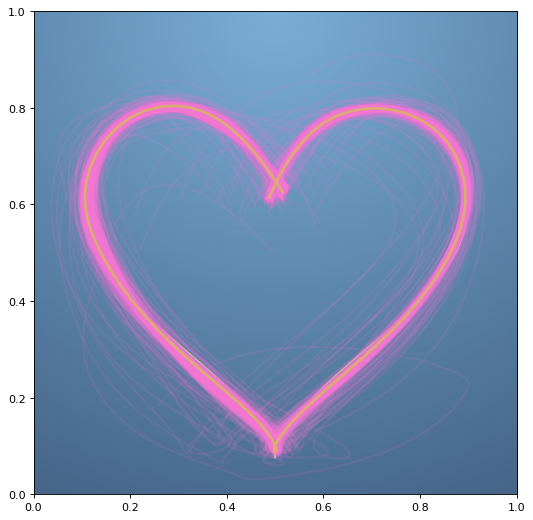

In [12]:
plot_training(x, y, iterations=100000, aggression=7, noise=1)

If you wish, we can change parameters of the steepest descent algorithm (We'll go into more details in future exercises), but you can change how many iterations are plotted, how agressive the step down the Jacobian is, and how much noise to add.

We can also edit the parameters of the neural network, i.e. to give it different amounts of neurons in the hidden layers by calling,
```python
reset_network(n1, n2)
```

